### PM4PY is a powerfull library used for process mining tasks, like discovering Petri nets. It has classes to represent Petri nets and to handle .xes files (event logs)

In [ ]:
!pip install pm4py

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.2 MB/s eta 0:00:00
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26097 sha256=9a29f8a63e903c5b46903492115b99e840cff1d41bac22169c267f458c5f6c26
  Stored in directory: /root/.cache/pip/wheels/31/d7/d9/eec6891f78cac19a693bd40ecb8365d2f4613318c145ec9816
Successfully built intervaltree


In [ ]:
import numpy as np
import pm4py
from pm4py.objects.petri_net.semantics import PetriNetSemantics
from pm4py.objects.petri_net.obj import PetriNet, Marking
from pm4py.objects.log.obj import EventLog
import random
import numpy as np
import os

/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 272, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


## PetriNet

A Petri net consists of two main components:

*   Places (represented as circles): These represent conditions, resources, or states in the system.

*   Transitions (represented as rectangles or bars): These represent events or actions that change the state of the system.



##Marking

Marking refers to the distribution of tokes across the places of a PetriNet.

For example, if you have a Petri net with places p1, p2, and p3, a marking could look like this:


marking = {p1: 1, p2: 0, p3: 2}
This means that:

Place p1 has 1 token.
Place p2 has no tokens.
Place p3 has 2 tokens.

In [ ]:
transition_counter = None
active_counter = None
DEBUG = False


def seed_everything(seed_value: int):
    random.seed(seed_value)
    np.random.seed(seed_value)
    os.environ["PYTHONHASHSEED"] = str(seed_value)


def get_selected_transition(n, label):
    """
    Returns the selected transition with the given label from the specified Petri net.

    Parameters:
    n (PetriNet): The Petri net to search for the transition in.
    label (str): The label of the transition to find.

    Returns:
    Transition: The selected transition with the given label, or None if not found.
    """
    #We loop over all transitions in PetriNet checking each label with the given one
    for t in n.transitions:
        if t.label == label:
            return t
    return None


def fire_transition(n, t, m): #firing means moving tokens from input places to output places
    """
    Fires a transition in a Petri net, updates the transition counter, and if DEBUG is true, prints the label of the fired transition.

    Args:
        n (PetriNet): The Petri net object.
        t (Transition): The transition to be fired.
        m (Marking): The current marking of the Petri net.

    Returns:
        Marking: The updated marking after firing the transition. A marking can be thought of as the "snapshot" of where the tokens are placed within the Petri net, reflecting the condition of each place.
    """
    global transition_counter
    active_transitions = pm4py.get_enabled_transitions(n, m) #retrieves all transitions enabled for the current marking
    markings = PetriNetSemantics.fire(n, t, m)
    for at in active_transitions:
        active_counter[at] += 1
    if DEBUG:
        print(f"Firing transition {t.label}")
    transition_counter[t] += 1
    return markings



In [ ]:
def backward_search(net: PetriNet, to_produce: str, initial_transitions: list[PetriNet.Transition], initial_markings: Marking):
    """
    Performs a backward search in a Petri net to find a sequence of transitions that can produce a given label or token.

    Args:
        net (PetriNet): The Petri net to search in.
        to_produce (str): The token to produce.
        initial_transitions (list[Transition]): The initial set of enabled transitions.
        initial_markings (Marking): The initial marking (state) of the Petri net.

    Returns:
        tuple: A tuple containing the resulting markings and a boolean indicating if a valid path was found.
            - If a valid path was found, the tuple contains the resulting markings after firing the transitions and True.
            - If no valid path was found, the tuple contains None and False.
    """

    def recursive_search(transitions: list[PetriNet.Transition], markings: Marking, selected_transition: PetriNet.Transition, depth: int = 0):
        """
        Recursively searches for a valid path in a Petri net exploring the places and transitions in reverse..

        Args:
            transitions (list[Transition]): List of all transitions in the Petri net.
            markings (Marking): Current marking of the Petri net.
            selected_transition (Transition): The transition to be fired.
            depth (int, optional): Current depth of the recursion. Defaults to 0.

        Returns:
            tuple: A tuple containing the new markings and a boolean indicating if a valid path was found.
        """
        visited.add((markings, selected_transition)) #to ensure to not visit again the same (state,transition) pair

        # sure I need to reach ALL the places that are in the input arcs of the selected transition
        places_to_reach = [a.source for a in selected_transition.in_arcs]

        transition_found = False
        for p in places_to_reach:
            if p in markings and markings[p] > 0:
                continue
            # if I reach the source or I come back to the original place, I can stop, it is the wrong path
            if p.name == 'source':
                return None, False

            possible_transitions = [
                a.source for a in p.in_arcs if a.source.label is None]
            # try to fire one of the possible transitions
            for t in possible_transitions:
                if (markings, t) in visited:
                    return None, False

                if t in transitions:
                    markings = fire_transition(net, t, markings)
                    transitions = pm4py.get_enabled_transitions(net, markings)
                    transition_found = True
                    return markings, True

            # if I didn't find any transition to fire, I need to go back recursively
            if not transition_found:
                for t in possible_transitions:
                    new_markings, right_path = recursive_search(
                        transitions, markings, t, depth+1)
                    if right_path:
                        return new_markings, True

        return None, False

    visited = set()
    # reverse search from the label
    target_transition = get_selected_transition(net, to_produce)
    return recursive_search(initial_transitions, initial_markings, target_transition)


In [ ]:
def replay_trace(net: PetriNet, im: Marking, perfect_trace: list[str]):
    """
    Replays a given trace (list of transitions) on a Petri net starting from an initial marking.
    It simulates how the system behaves when executing the trace, firing transitions step by step.
    The process continues until all transitions in the trace are fired, or it finds a dead-end where a transition cannot be fired.

    Parameters:
        net (PetriNet): The Petri net to replay the trace on.
        im (Marking): The initial marking of the Petri net.
        perfect_trace (list[str]): The trace to replay on the Petri net. (list of transitions label)

    Returns:
        Marking: The final marking after replaying the trace.

    """
    markings = im

    ended = False
    idx = 0
    while not ended:
        if idx == len(perfect_trace):
            break
        transitions = pm4py.get_enabled_transitions(net, markings)
        to_produce = perfect_trace[idx]
        found = False
        #For each label in the trace, it checks if the corresponding transition is enabled.
        #If the transition is found, it is fired, and the marking is updated.
        #ex. im[start] = 1 , One token at "Start" (Patient enters). If Triage fires the token is moved from Start to Triage
        '''markings = {
              start: 0,      # No patients in Start
              triage: 1,     # One patient in Triage
              blood_test: 0, # Not yet started
              treatment: 0,  # Not yet started
              discharge: 0   # Not yet started
          }'''
        for t in transitions:
            if t.label == to_produce:
                markings = fire_transition(net, t, markings)
                idx += 1
                found = True
                break
        if not found:
            if len(transitions) == 1:
                markings = fire_transition(net, list(transitions)[0], markings)
            else:
                #If the transition is not enabled (i.e., it cannot be fired directly),
                #the function calls backward_search to find an alternative path to the desired transition.
                markings, _ = backward_search(net, to_produce, transitions, markings)

## Petri Net Generation
Generate a Petri Net with a specific label and group of event logs, performing
discovery, trace alignement and visualization (updating counters).

In [ ]:
def generate_petrinet(label: str, group: EventLog):
    global transition_counter
    global active_counter

    print(f"Label: {label}")
    net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(group)

    pm4py.view_petri_net(net, initial_marking, final_marking, debug=False)

    # align the traces
    aligned_traces = pm4py.conformance_diagnostics_alignments( #allows the function to see how well the event logs fit the discovered Petri net.
        group,
        net,
        initial_marking,
        final_marking,
        multi_processing=False
    )
    # filtra le aligned traces rimuovendo le silent transitions (rettangoli neri), tenendo solo eventi reali oppure aggiustando l'ordine degli eventi
    perfect_traces = [[t[1] for t in aligned_traces[i]['alignment'] if t[1] is not None] for i in range(len(aligned_traces))]

    transition_counter = {
        t: 0 for t in net.transitions
    }
    active_counter = {
        t: 0 for t in net.transitions
    }

    total_count = 0
    for i, pt in enumerate(perfect_traces):
        print("="*50)
        print(f"Replaying trace {i+1}/{len(perfect_traces)}")
        replay_trace(net, initial_marking, pt)

    total_count = sum(transition_counter.values())
    decoration_dict = {
        t:
            {   #numero di volte eseguita la transazione / numero di volte che si poteva eseguire
                'label': t.label + ', ' + str(round(transition_counter[t]/active_counter[t], 2)) if t.label is not None
                else ', ' + str(round(transition_counter[t]/total_count, 2))
            } for t in net.transitions
    }
    pm4py.view_petri_net(net, initial_marking, final_marking,
                         decorations=decoration_dict)


In [ ]:
def group_traces(event_logs: EventLog, unique_labels: list[str]):
    """
    Loops trough event logs and groups them based on "concept:name" field/final diagnosis.

    Parameters:
        event_logs (EventLog): The event logs containing traces.
        unique_labels (list[str]): The list of unique labels to group the traces by.

    Returns:
        dict: A dictionary where the keys are the unique labels and the values are the grouped traces.
    """

    groups = {}
    # group the traces by the label
    for label in unique_labels:
        groups[label] = pm4py.objects.log.obj.EventLog()
        for e in event_logs:
            if e._list[-1]['concept:name'] == label:
                groups[label].append(e)
    return groups



## Execution on SepsisCases.xes.xml
Event Log SepsisCases --> contain traces                                
Trace --> one patient's journey trough the hospital                      
Event in the trace --> specifical medical action                         
Each event has a name, timestamp and other attributes.



parsing log, completed traces ::   0%|          | 0/1050 [00:00<?, ?it/s]

Label: IV Liquid


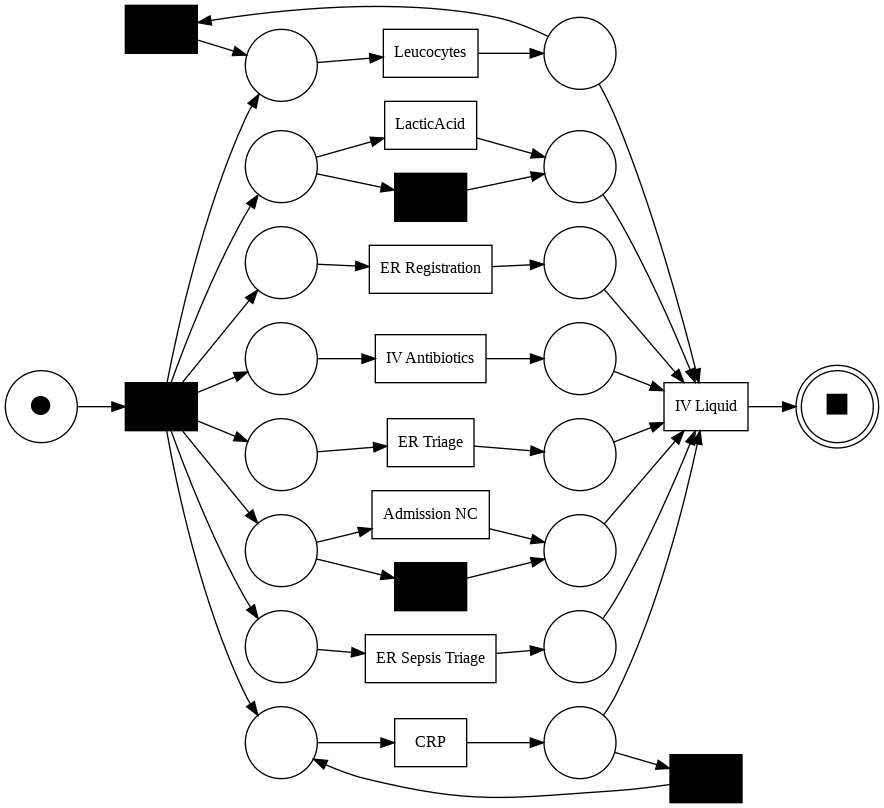

aligning log, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

Replaying trace 1/12
Replaying trace 2/12
Replaying trace 3/12
Replaying trace 4/12
Replaying trace 5/12
Replaying trace 6/12
Replaying trace 7/12
Replaying trace 8/12
Replaying trace 9/12
Replaying trace 10/12
Replaying trace 11/12
Replaying trace 12/12


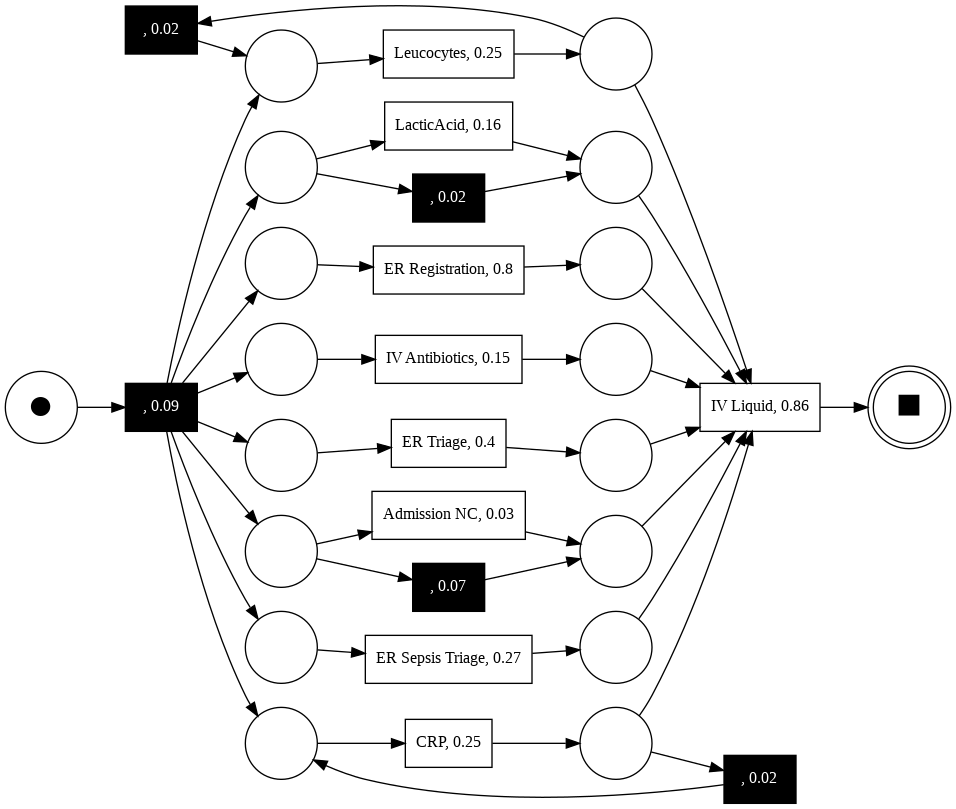

In [ ]:
seed_everything(1)
log = pm4py.read_xes("/content/drive/MyDrive/es4_Biomedical/SepsisCases.xes.xml")
el = pm4py.convert_to_event_log(log)
# Extract last event in each trace
unique_labels = set(el[i]._list[-1]['concept:name']for i in range(len(el))) #len(el) = 1050
# Groups based on their final diagnosis because it helps analyze how different patient cases progress and end
groups = group_traces(el, unique_labels) #groups size is 14
for label in list(unique_labels)[1:2]:
  generate_petrinet(label, groups[label])



# I rettangoli generati sono le transitions (ER Registration, Antibiotics, etc.)
# I cerchi sono gli stati del processo ("Waiting for ...", "Ready for ...")
# Le frecce o archi definiscono l'ordine tra stati e transizioni
# I rettangoli neri sono detti invisible transitions che avvengono per tre motivi
#  1) paziente salta uno step nel real world che in realtà esiste nel modello
#  2) paziente fa uno step in più nel real process
#  3) necessario per allineare real trace con il modello
# Se i numeri nei rettangoli neri sono alti vuol dire che è ci sono state molte deviazioni
# Il numero nel rettangolo bianco è calcolato come numero di volte eseguita la transazione / numero di volte che si poteva eseguire

In [ ]:
el[0]._list[-1]['concept:name']

'ER Sepsis Triage'

In [ ]:
unique_labels

{'Admission NC',
 'CRP',
 'ER Sepsis Triage',
 'ER Triage',
 'IV Antibiotics',
 'IV Liquid',
 'LacticAcid',
 'Leucocytes',
 'Release A',
 'Release B',
 'Release C',
 'Release D',
 'Release E',
 'Return ER'}